In [1]:
reference_scans_dir = "/Users/davidkorcak/Documents/Rakathon2025/data/radioprotect/Organized_CT_Data/SAMPLE_001/2023-06-05/frame_uid_1_2_246_352_221_559666980133719263215614360979762074268"

measurement_scans_dir = "/Users/davidkorcak/Documents/Rakathon2025/data/radioprotect/Organized_CT_Data/SAMPLE_001/2023-06-21/frame_uid_1_2_246_352_221_523526543250385987917834924930119139461"

In [2]:
import SimpleITK as sitk
import os

In [3]:
# Load Reference Scans
print(f"Loading reference scans from: {reference_scans_dir}")
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(reference_scans_dir)
reader.SetFileNames(dicom_names)
reference_image = reader.Execute()

print(f"Reference image loaded with size: {reference_image.GetSize()}")
reference_spacing = reference_image.GetSpacing()
print(f"Reference image spacing (x, y, z): {reference_spacing}")

Loading reference scans from: /Users/davidkorcak/Documents/Rakathon2025/data/radioprotect/Organized_CT_Data/SAMPLE_001/2023-06-05/frame_uid_1_2_246_352_221_559666980133719263215614360979762074268
Reference image loaded with size: (512, 512, 196)
Reference image spacing (x, y, z): (1.36523438, 1.36523438, 3.0)
Reference image loaded with size: (512, 512, 196)
Reference image spacing (x, y, z): (1.36523438, 1.36523438, 3.0)


In [4]:
# Load Measurement Scans
print(f"\nLoading measurement scans from: {measurement_scans_dir}")
reader = sitk.ImageSeriesReader()
# Check if the directory exists and is not empty before attempting to read
if os.path.exists(measurement_scans_dir) and len(os.listdir(measurement_scans_dir)) > 0:
    try:
        dicom_names = reader.GetGDCMSeriesFileNames(measurement_scans_dir)
        if not dicom_names:
            print(f"Warning: No DICOM series found in {measurement_scans_dir}")
            measurement_image = None
            measurement_spacing = None
        else:
            reader.SetFileNames(dicom_names)
            measurement_image = reader.Execute()
            print(f"Measurement image loaded with size: {measurement_image.GetSize()}")
            measurement_spacing = measurement_image.GetSpacing()
            print(f"Measurement image spacing (x, y, z): {measurement_spacing}")
    except Exception as e:
        print(f"Error reading measurement scans: {e}")
        measurement_image = None
        measurement_spacing = None
else:
    print(f"Warning: Measurement directory does not exist or is empty: {measurement_scans_dir}")
    measurement_image = None
    measurement_spacing = None


Loading measurement scans from: /Users/davidkorcak/Documents/Rakathon2025/data/radioprotect/Organized_CT_Data/SAMPLE_001/2023-06-21/frame_uid_1_2_246_352_221_523526543250385987917834924930119139461
Measurement image loaded with size: (512, 512, 93)
Measurement image spacing (x, y, z): (0.51119073851527, 0.51119073851527, 1.9897245368071947)


In [5]:
# Reference Point Cloud Data (using existing variables where possible)
reference_pointcloud_array = sitk.GetArrayFromImage(reference_image) 
reference_pointcloud_spacing = reference_image.GetSpacing()
reference_pointcloud_origin = reference_image.GetOrigin()

print("Reference Point Cloud Data:")
print(f" - Array Shape: {reference_pointcloud_array.shape}")
print(f" - Spacing (Scaling): {reference_pointcloud_spacing}")
print(f" - Origin: {reference_pointcloud_origin}")

# Measurement Point Cloud Data (using existing variables where possible)
measurement_pointcloud_array = sitk.GetArrayFromImage(measurement_image)
measurement_pointcloud_spacing = measurement_image.GetSpacing()
measurement_pointcloud_origin = measurement_image.GetOrigin()

print("\nMeasurement Point Cloud Data:")
print(f" - Array Shape: {measurement_pointcloud_array.shape}")
print(f" - Spacing (Scaling): {measurement_pointcloud_spacing}")
print(f" - Origin: {measurement_pointcloud_origin}")


Reference Point Cloud Data:
 - Array Shape: (196, 512, 512)
 - Spacing (Scaling): (1.36523438, 1.36523438, 3.0)
 - Origin: (-349.5, -253.5, -585.0)

Measurement Point Cloud Data:
 - Array Shape: (93, 512, 512)
 - Spacing (Scaling): (0.51119073851527, 0.51119073851527, 1.9897245368071947)
 - Origin: (-130.60923369065, -130.60923369065, -91.527328693131)


In [6]:
IM_RANGE_MIN = 0
IM_RANGE_MAX = 2**12 - 1

In [7]:
# Rescale to known range
rescaler = sitk.RescaleIntensityImageFilter()
rescaler.SetOutputMinimum(IM_RANGE_MIN)
rescaler.SetOutputMaximum(IM_RANGE_MAX)

clipped_ref_image = rescaler.Execute(reference_image)
clipped_meas_image = rescaler.Execute(measurement_image)

clipped_ref_array = sitk.GetArrayFromImage(clipped_ref_image).copy()
clipped_meas_array = sitk.GetArrayFromImage(clipped_meas_image).copy()

In [8]:
import numpy as np

In [9]:
# Clip the bed in the reference image
body_bbox = (150, 80, 340, 430)
mul_mask = np.zeros_like(clipped_ref_array[0])
mul_mask[body_bbox[0]:body_bbox[2], body_bbox[1]:body_bbox[3]] = 1.0
mul_mask = np.expand_dims(mul_mask, axis=0)

clipped_ref_array = clipped_ref_array * mul_mask

In [11]:
import matplotlib.pyplot as plt

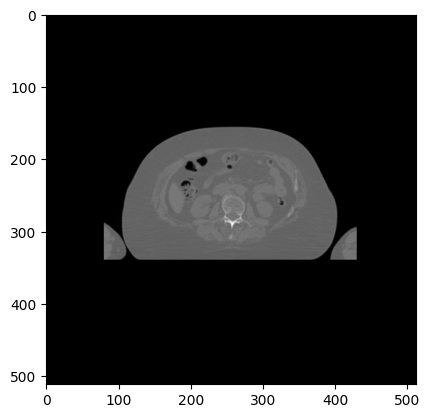

In [12]:
plt.imshow(clipped_ref_array[0, :, :], cmap="gray")

In [13]:
import torch

In [14]:
# Resample the reference scan to match the finer resolution of the measurement scan
reference_tensor = torch.from_numpy(clipped_ref_array)
measurement_tensor = torch.from_numpy(clipped_meas_array)

# Flip the scaling coefficients to (z,y,x)
reference_scale = torch.tensor(reference_pointcloud_spacing[::-1])
measurement_scale = torch.tensor(measurement_pointcloud_spacing[::-1])

print(f"Reference scale: {reference_scale}")
print(f"Measurement scale: {measurement_scale}")

# Extents of the scans 
reference_extents = torch.tensor(reference_tensor.shape) * reference_scale
measurement_extents = torch.tensor(measurement_tensor.shape) * measurement_scale
print(f"Reference extents: {reference_extents}")
print(f"Measurement extents: {measurement_extents}")


# Shape of the reference scan when resampled to the measurement scan's resolution
resampled_shape = torch.round(reference_extents / measurement_scale).long()
print(f"Resampled shape: {resampled_shape}")

# Interpolate the reference scan to match the measurement scan's resolution
reference_interp = torch.nn.functional.interpolate(
    reference_tensor.unsqueeze(0).unsqueeze(0).float(),
    size=resampled_shape.tolist(),
    mode='trilinear',
    align_corners=False
).squeeze(0).squeeze(0)

reference_interp.shape

Reference scale: tensor([3.0000, 1.3652, 1.3652])
Measurement scale: tensor([1.9897, 0.5112, 0.5112])
Reference extents: tensor([588., 699., 699.])
Measurement extents: tensor([185.0444, 261.7296, 261.7296])
Resampled shape: tensor([ 296, 1367, 1367])


torch.Size([296, 1367, 1367])

In [15]:
ref = reference_interp.clone()
meas = measurement_tensor.clone()

In [16]:
def equalize_colored_volume(volume):
    histc = torch.histc(volume, bins=IM_RANGE_MAX + 1, min=IM_RANGE_MIN, max=IM_RANGE_MAX)
    histc = histc.cumsum(dim=0)
    histc = torch.where(histc > 0, histc, 1e-6)
    cdf_min = torch.min(histc)
    cdf_max = histc[-1]
    cdf = (histc - cdf_min) / (cdf_max - cdf_min)
    cdf.clamp_(0, 1)
    return cdf[volume.long()]

In [17]:
equalized_reference_volume = equalize_colored_volume(ref)
equalized_measurement_volume = equalize_colored_volume(meas.float())

In [18]:
# Pad the equalized measurement volume to match the equalized reference volume size

# Get shapes of the volumes
ref_shape = equalized_reference_volume.shape
meas_shape = equalized_measurement_volume.shape

# Calculate the total padding needed for each dimension
delta_z = ref_shape[0] - meas_shape[0]
delta_y = ref_shape[1] - meas_shape[1]
delta_x = ref_shape[2] - meas_shape[2]

# Ensure padding is non-negative (should be the case if ref is larger or equal)
if delta_z < 0 or delta_y < 0 or delta_x < 0:
    raise ValueError("Measurement volume dimensions are larger than reference volume dimensions after resampling/interpolation.")

# Calculate padding amounts for each side (left/right, top/bottom, front/back)
# The order for torch.nn.functional.pad is (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back)
# This corresponds to padding the last dimension first, then second-to-last, etc.
padding = (
    delta_x // 2, delta_x - (delta_x // 2),  # Padding for width (dimension 2)
    delta_y // 2, delta_y - (delta_y // 2),  # Padding for height (dimension 1)
    delta_z // 2, delta_z - (delta_z // 2)   # Padding for depth (dimension 0)
)

# Pad the equalized measurement volume using constant padding with value 0
padded_measurement_volume = torch.nn.functional.pad(
    equalized_measurement_volume,
    padding,
    mode='constant',
    value=0
)

# Print shapes to verify
print(f"Reference shape: {ref_shape}")
print(f"Measurement shape before padding: {meas_shape}")
print(f"Calculated padding (x_left, x_right, y_top, y_bottom, z_front, z_back): {padding}")
print(f"Measurement shape after padding: {padded_measurement_volume.shape}")

Reference shape: torch.Size([296, 1367, 1367])
Measurement shape before padding: torch.Size([93, 512, 512])
Calculated padding (x_left, x_right, y_top, y_bottom, z_front, z_back): (427, 428, 427, 428, 101, 102)
Measurement shape after padding: torch.Size([296, 1367, 1367])


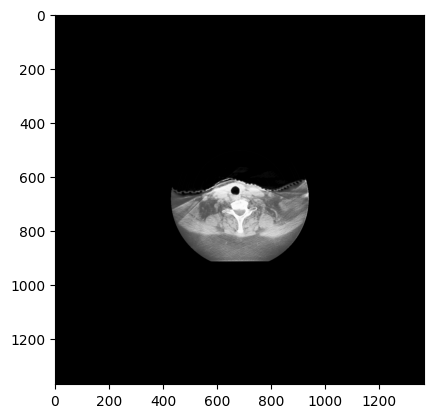

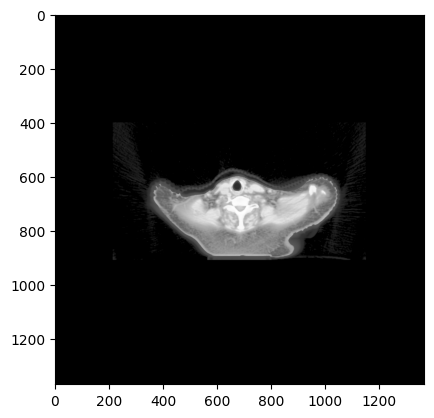

In [19]:
plt.imshow(padded_measurement_volume[160, :, :].detach().numpy(), cmap='gray')
plt.show()
plt.imshow(equalized_reference_volume[160, :, :].detach().numpy(), cmap='gray')
plt.show()

In [20]:
# Register with fourier transform
ref_fft = torch.fft.rfftn(equalized_reference_volume)
meas_fft = torch.fft.rfftn(padded_measurement_volume)
ref_fft_conj = torch.conj(ref_fft)
ref_fft_conj = torch.fft.fftshift(ref_fft_conj)
ref_fft_conj = torch.fft.fftshift(ref_fft_conj)
ref_fft_conj = torch.fft.ifftn(ref_fft_conj)

KeyboardInterrupt: 